# Exercises: Fitting a Linear Model with Gradient Descent

This notebook is a very important one.
We will return to our favorite problem: modeling the relationship between an NBA player's height and his wingspan using a linear model. 

Before, we found that we could exactly solve for the model parameters (i.e. the slope and y-intercept) that minimize the squared-residuals between our recorded data and our model's predictions. Now, we will act as if no such analytic solution exists, since this will almost always be the case in "real world" problems. Instead, we will use gradient descent to tune the parameters of our linear model, and we will do this by leveraging MyGrad's autodiff capabilities to compute the relevant gradients for this optimization process. The procedure that we exercise here will turn out to be almost exactly identical to the process for "training a neural network" using "supervised learning", which are concepts that we will dive into .

In [1]:
# Run this cell to import the necessary libraries

from pathlib import Path

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import numpy as np
import xarray as xr
import mygrad as mg

In [2]:
# Load the NetCDF-4 file `./data/nba_draft_measurements.nc` as an xarray-dataset
# (refer to the previous exercise notebook if you need a refresher on this)
draft_data = xr.load_dataset(Path.cwd() / "data" / "nba_draft_measurements.nc")

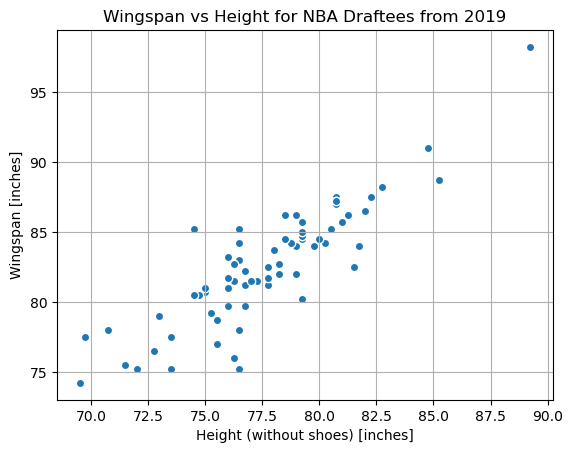

In [3]:
# A scatter plot that shows wingspan versus height (without shoes) for the players

fig, ax = plt.subplots()
draft_data.plot.scatter(x="height_no_shoes", y="wingspan")
ax.grid()
ax.set_xlabel("Height (without shoes) [inches]")
ax.set_ylabel("Wingspan [inches]");
ax.set_title("Wingspan vs Height for NBA Draftees from 2019");

## Reviewing Our Modeling Problem

Based on the relationship between height and wingspan that we visualized above, we want to define a **linear mathematical model that can predict an individual's wingspan based on their height**.

Our recorded data consists of $N$ measurements: $\big(x_n, y^{\mathrm{(true)}}_n\big)_{n=0}^{N-1}$.
Datum-$i$, $\big(x_i, y^{\mathrm{(true)}}_i\big)$,  is the height and wingspan of player-$i$.
We use the "true" superscript label here in anticipation of the fact that we will need to distinguish these measured wingspans from our model's predicted wingspans.
Supposing we have some values picked out for our model's parameters, $m$ and $b$, then our model's predicted wingspan for player-$i$ is

\begin{equation}
y^{\mathrm{(pred)}}_i = F(m, b; x_i) = m x_i + b
\end{equation}

Our goal is to find appropriate values for our model's parameters, $m$ and $b$, such that $F(m, b; x)$ will make reliable predictions about the wingspans of players whose measurements are not in our dataset.
The way that we will measure the quality of our model's predictions is via the loss function (a.k.a objective function) that computes the mean squared-error (a.k.a squared residuals) of our predictions compared to our recorded data.

\begin{equation}
\mathscr{L}_{\mathrm{MSE}} = \frac{1}{N}\sum_{n=0}^{N-1}{\big(y^{\mathrm{(true)}}_n - y^{\mathrm{(pred)}}_n\big)^2}
\end{equation}

**To find the values of** $m$ **and** $b$ **that minimize** $\mathscr{L}_{\mathrm{MSE}}$ **is to produce the best-fit linear model - the one that minimizes empirical risk - for this dataset.**
We will denote these optimal model parameter values as $m^*$ and $b^*$.

The following function computes values of $m^*$ and $b^*$ – the ideal slope and y-intercept for our linear model – based on the particular values of our dataset, $\big(x_n, y^{\mathrm{(true)}}_n\big)_{n=0}^{N-1}$.

We will be making use of this analytical solution so that we can precisely measure how far our approximate solution is away from the ideal; keep in mind that for most problems we will not have access to an exact solution like this.
You already coded up `ordinary_least_squares` in the Data Exploration notebook; copy & paste your solution from that notebook below 

In [4]:
def ordinary_least_squares(x, y):
    """
    Computes the slope and y-intercept for the line that minimizes
    the sum of squared residuals of mx + b and y, for the observed data
    (x, y).

    Parameters
    ----------
    x : numpy.ndarray, shape-(N,)
        The independent data. At least two distinct pieces of data
        are required.

    y : numpy.ndarray, shape-(N,)
        The dependent data in correspondence with ``x``.

    Returns
    -------
    (m, b) : Tuple[float, float]
        The optimal values for the slope and y-intercept
    """
    # Refer to the Data Exploration notebook. Copy/paste your solution here
    # STUDENT CODE HERE
    m = (x @ y - np.sum(x)*np.sum(y)/len(x))/(x @ x - np.sum(x)*np.sum(x)/len(x))
    b = (np.sum(y) - np.sum(x)*m)/len(x)
    return (m, b)

Using this function, compute the parameters, $m^*$ and $b^*$, that minimize the MSE of a linear model for our dataset, where $x$ corresponds to "height" (without shoes) and $y$ corresponds to wingspan.
We will want to access the underlying NumPy arrays from the xarray data so that you can work with the "raw data" conveniently here.

In [5]:
# Compute m* and b* that best fits the wingspan vs height (no shoes) data

# Access the underlying numpy arrays  (recall that `.data` returns the numpy array of an xarray)
height = draft_data.height_no_shoes.data # access the players' heights (no shoes) from `draft_data`
wingspan = draft_data.wingspan.data # access the player's wingspans from `draft_data`


# Compute the ideal parameter values for our linear model, based on this data
m, b = ordinary_least_squares(wingspan, height) #  compute m* and w* for our data

Next, plot the data for this problem along with the resulting fitted linear model.
Use `ax.scatter` to plot the original data and `ax.plot` to draw the model line; 
you will want to specify a distinct color for your linear model.
Label your axes.

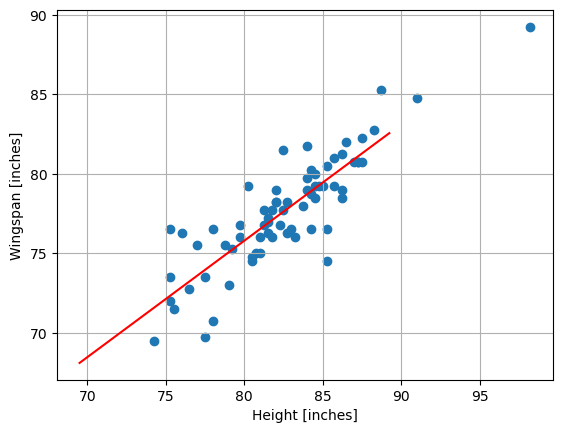

In [6]:
# Plot wingspan vs height (no shoes) as a scatter plot
# Plot the line: m* x + b*
fig, ax = plt.subplots()

ax.scatter(wingspan, height)  # plots our raw data

min_height = np.min(height) # compute the smallest height
max_height = np.max(height) # compute the largest height


x_values = x = np.linspace(min_height, max_height, 1000) # use np.linspace to make a shape-(1,000) array of values evenly spaces across [min_height, max_height] 
y_values = m * x + b # use `x_values`, `m`, and `b`, and compute the corresponding y-values for our line

ax.plot(x_values, y_values, c="red")

ax.grid(True)
ax.set_xlabel("Height [inches]")
ax.set_ylabel("Wingspan [inches]");

The following function creates a surface plot of $\mathscr{L}_{\mathrm{MSE}}(m, b)$ over a range of $(m, b)$ values, given a user-specified data set.
Take a moment to read its docstring and then run this cell to define the function.

**You don't need to modify the following function at all. Just read through the docstring and run this cell**


In [7]:
# You don't need to modify this function at all. Just read
# through the docstring and run this cell 

def graph_linear_regression_mse(
    x,
    y,
    trajectory=None,
    m_scale=10,
    b_scale=10,
    sample_density=500,
):
    """
    Given the data `x, y`, plots the mean squared-error (MSE) surface on the space of 
    possible slope and y-intercept values for a linear regression model.

    The plot is automatically centered at the optimal parameter values (m*, b*); this
    point is demarcated with a black dot.

    Parameters
    ----------
    x : np.ndarray, shape-(N,)
        The x data from your dataset

    y : np.ndarray, shape-(N,)
        The y data from your dataset

    trajectory : Optional[np.ndarray], shape-(T, 2) or shape-(N, T, 2)
        One or more length-T sequence of (slope, intercept) points to superimpose over the surface.
        This can be used to display a "trajectory" of parameter values.

    m_scale : int, optional (default=10)
        The size of the range of slopes that are plotted in each direction

    b_scale : int, optional (default=10)
        The size of the range of y-intercepts that are plotted in each direction

    sample_density : int, optional (default=500)
        The number of samples to calculate along each axis. Decreasing this speeds
        up the plot at the cost of visual quality.
    
    Returns
    -------
    Tuple[Figure, Axis]
        Returns the matplotlib figure and axis that was created so
        that the plot can be further manipulated or saved. 
    """

    def mse(x, y, m, b):
        """Computes the mean squared-error (MSE)"""
        m = np.atleast_1d(m)
        b = np.atleast_1d(b)
        return ((x * m[None] + b[None] - y) ** 2).mean(axis=1)

    # find least squares solution
    A = np.vstack([x, np.ones(len(x))]).T
    m_opt, b_opt = np.linalg.lstsq(A, y, rcond=None)[0]
    l_opt = mse(x, y, m_opt, b_opt)

    center_m = m_opt
    center_b = b_opt

    # Creates the plot figure
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # Plot the local minimum of the MSE surface as a black dot
    ax.plot(
        [m_opt],
        [b_opt],
        l_opt,
        c="black",
        marker="o",
        zorder=3,
        markersize=7,
    )

    # Define quadratic surface of MSE landscape over m and b
    m_series = np.linspace(center_m - m_scale, center_m + m_scale, sample_density)
    b_series = np.linspace(
        center_b - b_scale, center_b + b_scale, sample_density
    ).reshape(-1, 1)

    Z = (b_series + x.reshape(-1, 1, 1) * m_series) - y.reshape(-1, 1, 1)

    Z = np.mean(Z ** 2, axis=0)

    # make surface plot
    m_series, b_series = np.meshgrid(m_series, b_series)
    ax.set_xlabel("Slope: m")
    ax.set_ylabel("Intercept: b")
    ax.set_zlabel("MSE Loss")
    ax.ticklabel_format(style="sci", scilimits=(-1, 2))
    ax.dist = 11
    surf = ax.plot_surface(m_series, b_series, Z, cmap=plt.get_cmap("GnBu"))

    # Graphs one or more trajectories on the loss londscape
    if trajectory is not None:
        trajectories = np.atleast_2d(trajectory)
        if trajectories.ndim == 2:
            trajectories = trajectories[np.newaxis]
        for trajectory in trajectories:
            m_values, b_values = trajectory.T
            l_values = ((x * m_values[:, None] + b_values[:, None] - y) ** 2).mean(
                axis=1
            )
            ax.plot(
                m_values,
                b_values,
                l_values,
                marker="*",
                zorder=3,
                markersize=7,
            )
    return fig, ax

Here we use `graph_linear_regression_mse` for our dataset.


The ideal solution will appear as a black dot, and our model's slope/intercept values will be a orange start.
Because we used `ordinary_least_squares` to compute `m` and `b`, the orange star should match the black dot perfectly.

Note that you can click-and-drag your cursor over the plot to rotate it

/var/folders/rk/9p1bkflx7xqfp9blzn6sypv00000gn/T/ipykernel_7228/2126346202.py:93: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='Slope: m', ylabel='Intercept: b', zlabel='MSE Loss'>)

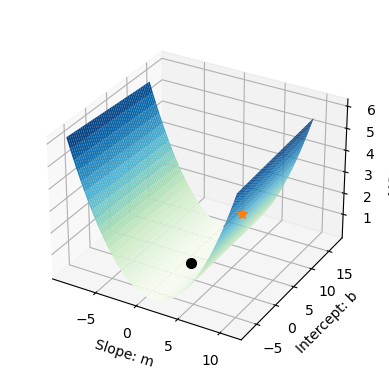

In [8]:
# Run this cell

# plotting the linear regression MSE surface with your solution point included

graph_linear_regression_mse(height, wingspan, trajectory=[m, b])

This surface is our so-called **loss landscape**.
It represents the values of $\mathscr{L}_{\mathrm{MSE}}$ over a continuum of $(m, b)$ parameter values.
That is, given our fixed dataset, this depicts how well (or poorly) the various linear models of differing slopes and y-intercepts would fit the data.
The ideal model is the one whose parameter values reside at the bottom of this loss-landscape.
Typically we will use gradient descent to search for these ideal values that minimize $\mathscr{L}$; as such, that is what we will be doing in the rest of this notebook.

Before we proceed, note that our loss landscape looks much more like a taco shell (or a half pipe) than it does like a bowl, even though our equation for $\mathscr{L}_{\mathrm{MSE}}$ is quadratic in $m$ and $b$ (and 2D quadratic surfaces generally look like bowls).
Even though the landscape looks flat along $b$, it is actually sloping upward away from the black dot; the slope is simply far more mild along the $b$ direction than it is along the $m$ direction.
How might this affect the search for the minimum on this surface via gradient descent?

## Estimating Optimal Model Parameters Using Gradient Descent

In keeping with our [discussion of gradient-based learning](https://rsokl.github.io/CogWeb/Video/Gradient_Descent.html) we will arrive at near-optimal values for our model's parameters by utilizing gradient descent.

We will start this process by crudely drawing (small) random values for $m$ and $b$; these will determine where we first reside on the loss landscape.

\begin{align}
m_{old}, b_{old} \leftarrow \mathrm{randomly\;sampled\;values}
\end{align}

Next we'll descend this loss landscape by iteratively updating the values for $m$ and $b$ with the gradient-based step


\begin{align}
\begin{bmatrix}m_\text{new} \\ b_\text{new} \end{bmatrix} &= \begin{bmatrix} m_\text{old} \\ b_\text{old} \end{bmatrix} - \delta \vec{\nabla} \mathscr{L}_{MSE} (m_{\text{old}}, b_{\text{old}})\\
   &\Downarrow(\mathrm{equivalent\;to...})\\
   m_\text{new} &= m_\text{old} - \delta \frac{\mathrm{d}\mathscr{L}_{MSE}}{\mathrm{d} m}\big|_{m_{old}, b_{old}}\\
   b_\text{new} &= b_\text{old} - \delta \frac{\mathrm{d}\mathscr{L}_{MSE}}{\mathrm{d} b}\big|_{m_{old}, b_{old}}\\
\end{align}

where $\delta$ is the learning rate - a single, positive valued number that we have to pick.

Keep in mind that we will be able to leverage automatic differentiation, via MyGrad, to compute $\vec{\nabla} \mathscr{L}_{MSE} (m_{\text{old}}, b_{\text{old}})$.

Complete the following function that performs a gradient-step on all of the supplied parameters.
Note that this was a reading comprehension task - "Writing a Generic Gradient-Update Function" - in [a previous section](https://rsokl.github.io/CogWeb/Video/Automatic_Differentiation.html#Gradient-Descent-with-MyGrad).
You can refer back to the solution at the bottom of the page for assistance with this function.

In [9]:
# Copy and paste the solution that you wrote in Autodiff & Grad_Descent

def gradient_step(tensors, learning_rate):
    """
    Performs gradient-step in-place on each of the provides tensors 
    according to the standard formulation of gradient descent.

    Parameters
    ----------
    tensors : Union[Tensor, Iterable[Tensor]]
        A single tensor, or an iterable (e.g a list) of an arbitrary number of tensors.

        If a `tensor.grad` is `None`for a specific tensor, the update on
        that tensor is skipped.

    learning_rate : float
        The "learning rate" factor for each descent step. A positive number.

    Notes
    -----
    The gradient-steps performed by this function occur in-place on each tensor,
    thus this function does not return anything
    """
    # If `tensors` is a single Tensor, make it into a list containing that tensor
    if isinstance(tensors, mg.Tensor):
        # Only one tensor was provided. Pack
        # it into a list so it can be accessed via
        # iteration
        tensors = [tensors]

    # Iterate over `tensors`, which is a list of Tensor-instances, using a for-loop.
    #
    # Update each tensor's underlying data (`.data`) using the gradient-step.
    # If the tensor's gradient is not set (i.e. it is `None`), skip the tensor
    #
    #  For each tensor in tensors...
    #      If the .grad of tensor is not None...
    #          Update the .data attribute of the tensor using the gradient-descent step
    for t in tensors:
        if t.grad is not None:
            t.data -= learning_rate * t.grad

Now let's code up $\mathscr{L}_{MSE}$ in MyGrad. Recall that the equation for $\mathscr{L}_{MSE}$ is:

\begin{equation}
\mathscr{L}_{\mathrm{MSE}} = \frac{1}{N}\sum_{n=0}^{N-1}{\big(y^{\mathrm{(true)}}_n - y^{\mathrm{(pred)}}_n\big)^2}
\end{equation}

We want to leverage [vectorized math functions](http://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/VectorizedOperations.html) to ensure that this function runs efficiently. Consider referencing [these functions](https://mygrad.readthedocs.io/en/latest/math.html#sums-products-differences) in particular.

In [10]:
# Complete the following function

import mygrad as mg
import numpy as np

def mean_squared_error_mygrad(y_pred, y_true):
    """ Computers the mean-squared error for a collection of predictions
    and corresponding true values.
    
    Parameters
    ----------
    y_pred : mygrad.Tensor, shape-(N,)
        A tensor of N predictions.

    y_true : array_like, shape-(N,)
        An array of N corresponding true values
    
    Returns
    -------
    mse : mygrad.Tensor, shape-()
        A scalar-tensor containing the mean squared-error.
    
    Examples
    --------
    >>> pred = mg.tensor([1., 2., 3.])
    >>> true = mg.tensor([1., 1., 3.])
    >>> mean_squared_error_mygrad(pred, true)
    Tensor(0.33333333)
    """
    # This code should only use vectorized operations
    
    differences = y_pred - y_true # Compute the difference between the predicted values and true values
    squared_differences = differences ** 2 # Square each difference
    mean_of_squared_differences = np.sum(squared_differences)/len(squared_differences) # Compute mean of the squared-differences
    
    # Return mean_of_squared_differences
    return mean_of_squared_differences

In [11]:
# Test your code

# Create a test case where `y_pred` and `y_true` match perfectly.
# What should `mean_squared_error_mygrad` return in this case?
# Check that `mean_squared_error_mygrad` performs as-expected

y_pred = mg.tensor([4, 5, 8]) #
y_true = mg.tensor([4, 5, 8]) #

print("MSE for perfect match:", mean_squared_error_mygrad(y_pred, y_true))

# Create a test case where:
# - `y_true` is tensor([0., 0.])
# - `y_pred` is tensor([1.0, -1.0])
#
# What should `mean_squared_error_mygrad` return in this case? Compute it by-hand.
# Check that `mean_squared_error_mygrad` performs as-expected

y_pred = mg.tensor([1.0, -1.0])#
y_true = mg.tensor([0., 0.])#

print("MSE for [0, 0] vs [1, -1]:", mean_squared_error_mygrad(y_pred, y_true))

MSE for perfect match: Tensor(0.)
MSE for [0, 0] vs [1, -1]: Tensor(1.)


## Defining Our Linear Model

We will now [create a class](https://www.pythonlikeyoumeanit.com/module_4.html) used to encapsulate the parameters and functionality of our linear model.
Although this might seem to be excessive here, this will prime us for creating more sophisticated models (e.g. neural networks) later on.

This class will be responsible for:

- drawing random values to initialize `m` and `b`; we will use the [`uniform`](https://mygrad.readthedocs.io/en/latest/generated/mygrad.nnet.initializers.uniform.html) function to draw these values.
- storing our model parameters `m` and `b` and making them easily accessible
- defining the so-called "forward pass" of our model: passing data to it and returning predictions

In [12]:
# We will use `uniform` to draw random initial values for our model's parameters
# After running this cell, use <SHIFT>+<TAB> to look up the documentation
# for `uniform`
from mygrad.nnet.initializers import uniform

In [13]:
class LinearModel:
    """
    A linear model with parameters `self.m` and `self.b`
    """
    
    def initialize_params(self):
        """
        Uses `mygrad.nnet.initializers.uniform` to draw tensor
        values for both `self.m` and `self.b` from the uniform 
        distribution [-10, 10].
        
        Both parameters should be shape-(1,) tensors; the call:
        
           uniform(1, lower_bound=-10, upper_bound=10)
        
        will draw a shape-(1,) tensor from this distribution
        """
        # Using the function `uniform`, draw a shape-(1,) tensor from 
        # the domain [-10, 10].
        # Do this for both m and b, respectively.
        self.m = uniform(1, lower_bound=-10, upper_bound=10)  # <COGSTUB>
        self.b = uniform(1, lower_bound=-10, upper_bound=10)  # <COGSTUB>
        
    def __init__(self, m=None, b=None):
        """ Accepts initial values for m and b. If either are not
        specified, uses `self.initialize_params()` to draw them
        randomly
        
        Parameters
        ----------
        m : Optional[mygrad.Tensor], shape-(1,)
            The slope for the linear model. If `None`, a random
            value is drawn.
            
        b : Optional[mygrad.Tensor], shape-(1,)
            The y-intercept for the linear model. If `None`, a random
            value is drawn.
        """
        
        #
        # If either parameter is provided as an input to this method, 
        # use that specified value to overwrite the randomly drawn value
        #
        # `self.m` and `self.b` must be defined by this method
                
        # Use `self.initialize_params()` to draw random values for `self.m` and `self.b`. 
        self.initialize_params()  # <COGLINE>
        
        # If `m` is not `None, then assign it to `self.m`
        # If `b` is not `None, then assign it to `self.b`
        # <COGINST>
        if m is not None:
            self.m = m

        if b is not None:
            self.b = b
        # </COGINST>
    
    def __call__(self, x):
        """
        Performs: m * x + b
        
        This is known as a 'forward pass' through the model
        on the specified data. I.e. uses the linear model to
        make a prediction based on the input `x`.
        
        Parameters
        ----------
        x : array_like, shape-(N,)
            An array or tensor of N observations.
        
        Returns
        -------
        prediction : mygrad.Tensor, shape-(N,)
            A corresponding tensor of N predictions based on
            the linear model.
        """
        # Using your model's parameters (`self.m` and `self.b`) and x, compute 
        # the line's output y
        
        # <COGINST>
        y = self.m * x + self.b
        return y
        # </COGINS>
    
    @property
    def parameters(self):
        """ Returns a tuple of the tensors associated with the model's
        parameters.
        
        This is accessed as an attribute, via `model.parameters`
        *not* as a method (i.e. not as `model.parameters()`)
        
        Returns
        -------
        Tuple[Tensor, Tuple]
            A tuple containing all of the learnable parameters for our model.
            
            This should return a tuple containing the slope and y-intercept 
            associated with the model.
        
        Examples
        --------
        >>> model = LinearModel()
        >>> model.parameters
        (Tensor([-7.714269], dtype=float32), Tensor([-6.770146], dtype=float32))
        """
        # return `self.m` and `self.b` as a tuple
        return (self.m, self.b)  # <COGLINE>

## "Training" Our Model

We will now use gradient descent to optimize our model's parameter values based on our recorded data.
In the parlance of modern machine learning, this process is typically described as us "training" our model.
And to introduce more terminology, the pattern of machine learning that we are about to invoke is called **supervised learning**: it is the process of training (updating) our model based off of collected data where we have access to the desired predictions that we want our model to make. That is, for each recorded height that we are going to feed to our model, we have an associated true wingspan that we measured and that we want our model to predict.

### Using Un-Normalized Data (This Won't Work Well)

To start off, we will attempt to search for ideal model parameters by processing our raw data (we will find that this works only moderately well and that we ought to pre-process our data before using it to train our model).   

In [14]:
# Checking that your model class is working as-expected

# <COGINST>
model = LinearModel()  # Initialize your linear model without specifying any input parameters.

assert isinstance(model.m, mg.Tensor) and model.m.shape == (1,)

assert isinstance(model.b, mg.Tensor) and model.b.shape == (1,)

assert model.parameters == (model.m, model.b)

output = model(1)
assert isinstance(output, mg.Tensor) and output.size == 1
# </COGINST>

**Run the following cell without modifying it**

In [15]:
# This cell defines a convenience function for measuring the
# distance between (m, b) and (m*, b*)
 
true_params = np.array(ordinary_least_squares(height, wingspan))

def dist_from_true(model_params, true_params) -> float:
    """ Computes sqrt[(m - m*)^2 + (b - b*)^2]
    
    Parameters
    ----------
    model_params : Tuple[Tensor, Tensor]
        m and b
    
    true_params : numpy.ndarray, shape-(2,)
        m* and b*
    
    Returns
    -------
    float
        The L2 distance between the parameters"""
    params = np.array([i.item() for i in model_params])
    return np.sqrt(np.sum((true_params - params) ** 2))

In [16]:
heights = draft_data.height_no_shoes.data  # our observed data: x [inches]
wingspans = draft_data.wingspan.data       # our observed data: y [inches]

model = LinearModel() # Initialize your linear model without specifying any input parameters.


# `trajectory` is a list that will store the sequence of estimated 
# model parameters that we compute during gradient descent:
#           [(m0, b0), (m1, b1), ... ]
# Keep this as an empty list, it will be updated later.
trajectory = []  


# This is the number of times we will process the observed data
# and perform an update our model's parameters
#
# An "epoch" denotes our having processed the dataset in its
# entirety once. Thus we will train our model by processing 
# our dataset in full`num_epoch` times.
num_epochs = 10


# The learning rate used for gradient descent. 
#
# This is a value that we need to choose. The following is simply
# an educated guess of a good learning rate; there is a whole art
# to making educated guesses and well-informed choices for learning
# rates, which we will discuss later. The key thing to note here is that
# there was no principled reason behind our picking this *exact* value
learning_rate = 1E-4

The following cell initialized a plot using the [noggin library](https://github.com/rsokl/noggin).
This library is capable of logging measurements taken from an experiment and plot them in real time.
Here, we tell noggin that we want to track four measured "metrics"

- `"loss"`: the value of $\mathscr{L}_{MSE}$ for our current model parameters
- `"m:`: the current slope of our model
- `"b:`: the current y-intercept of our model
- `"dist_from_target:`: the Euclidean distance of our model's $(m, b)$ from the optimal $(m^*, b^*)$

/Users/aadishah/anaconda3/envs/week1/lib/python3.8/site-packages/noggin/plotter.py:364: UserWarning: Live plotting is not supported when matplotlib uses the 'module://matplotlib_inline.backend_inline'
backend. Instead, use the 'nbAgg' backend.

In a Jupyter notebook, this can be activated using the cell magic:
   %matplotlib notebook.
  warn(cleandoc(_inline_msg.format(self._backend)))


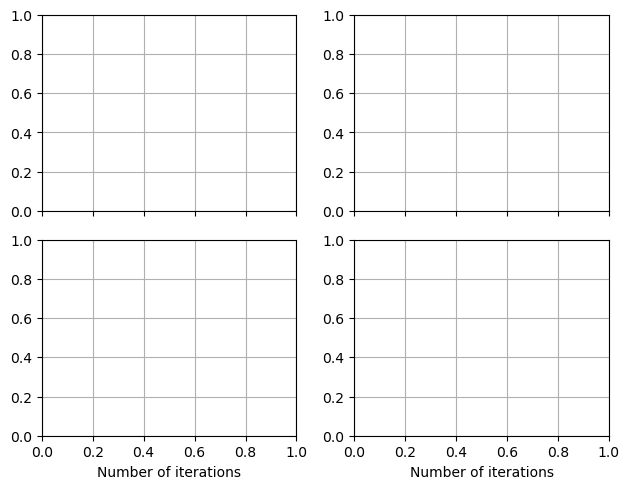

In [17]:
# The plot created here will update in real time as we run our experiment
# Run this cell

from noggin import create_plot

# Four "metrics" will be tracked by the plotter
plotter, fig, ax = create_plot(["loss", "m", "b", "dist_from_target"], ncols=2)

In [18]:
# The code in this cell will be responsible for training our model

# Fill out the following code blocks and then run this cell.
# View the noggin plot above to see the recorded metrics

for n in range(num_epochs):
    # Perform a "forward pass" with your model on the *full* set of heights
    # I.e. feed the model all N heights to produce N corresponding predictions
    # using your linear model
    y_pred = model(heights)  # <COGSTUB>
    
    # Compute the mean-squared error of your model's predictions compared
    # to the true wingspans, using your loss function. 
    # (Recall that you defined this function earlier).
    loss = mean_squared_error_mygrad(y_pred, wingspans) # <COGSTUB>
    
    # Invoke "back-propagation" from the computed loss.
    # This will use mygrad's auto-differentiation abilities to compute the derivatives
    # of the loss with respect to your model's parameters.

    loss.backward()  # <COGLINE>
    
    
    # This feeds our four measured metrics to noggin to be logged and plotted
    # DON'T CHANGE THIS
    plotter.set_train_batch(
        dict(
            loss=loss,
            m=model.m.item(),
            b=model.b.item(),
            dist_from_target=dist_from_true(model.parameters, true_params),
        ),
        batch_size=len(y_pred),
    )
    
    # Appends the current model params to the "trajectory" list
    # Don't change this.
    trajectory.append((model.m.item(), model.b.item()))
    
    # Perform a single update to your model's parameters using gradient descent.
    #
    # Access your model's parameters as a tuple (refer back to `LinearModel` to see how to do this).
    # Pass these parameters and the learning rate to `gradient_step`.
    # Recall that `gradient_step` doesn't return anything; it updates your model parameters in-place.

    gradient_step(model.parameters, learning_rate=learning_rate)  # <COGLINE>
    
    # Now your model's parameters have been "nudged" slightly, via the gradient-descent step so as 
    # to improve its predictions on this dataset (i.e. to help *minimize* the loss).

# This ensures that noggin plots any lingering measurements
plotter.plot()

# When you run this cell, the noggin plot above will update in real time.
# Study the plot: 
#  - Does the loss go down?
#  - Do the values of `m` and `b` converge?
#  - Does the distance from the target go to 0? (it likely won't this time.. we'll see why)  

What does the graph of `dist_from_target` tell us about our approximate solution?
Let's print out the last value of this metric associated.

In [19]:
# Prints the distance between our approximate solution and the exact one
train_metrics = plotter.to_xarray("train").batch

print("distance from target:", round(train_metrics.dist_from_target[-1].item(), 2))

distance from target: 6.6


Let's visualize the "trajectory" of our model's parameter values – depicting how they evolved throughout "training".
Does your the terminus of the trajectory end near the optimal solution?

/var/folders/rk/9p1bkflx7xqfp9blzn6sypv00000gn/T/ipykernel_7228/2126346202.py:93: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


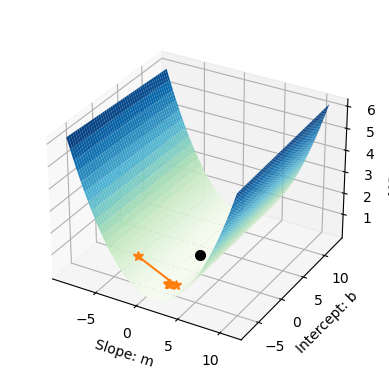

In [20]:
graph_linear_regression_mse(height, wingspan, trajectory=trajectory);

Let's see how well our learned model matches our data.
The following plot will compare your learned model against the ideal model, derived from the closed-form solution to the least-squares problem.

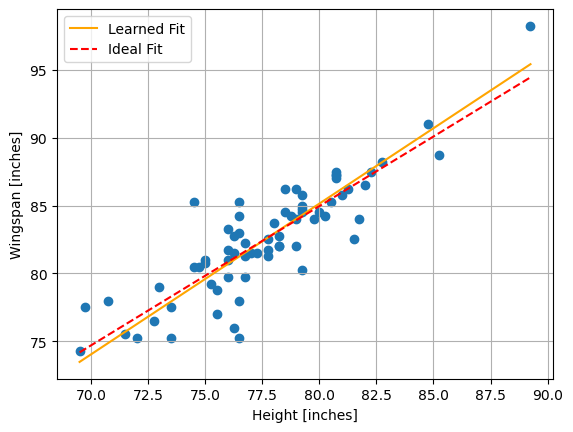

In [21]:
# Run this
fig, ax = plt.subplots()

ax.scatter(height, wingspan)
m, b = ordinary_least_squares(height, wingspan)

x = np.linspace(height.min(), height.max(), 1000)

ax.plot(x, model.m * x + model.b, c="orange", label="Learned Fit")
ax.plot(x, m * x + b, c="red", ls="--", label="Ideal Fit")
ax.legend()
ax.grid(True)
ax.set_xlabel("Height [inches]")
ax.set_ylabel("Wingspan [inches]");

You might see that the learned model does not match the least-squares solutions so closely (if it does match, then you got lucky! Try training the model again).
It may match the model near the center of the data, but extrapolating outward would reveal discrepancies.

Let's see just how varied our models will be.
The following will train an "ensemble" of linear models in identical fashions - but with different randomly-drawn parameters.
It will then plot the trajectory associated with each model.

/var/folders/rk/9p1bkflx7xqfp9blzn6sypv00000gn/T/ipykernel_7228/2126346202.py:93: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


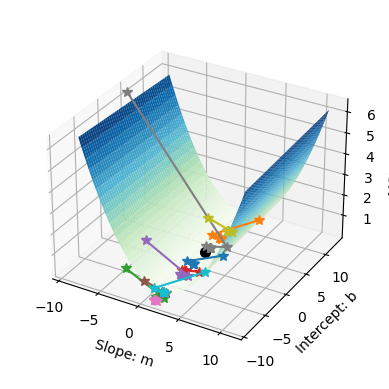

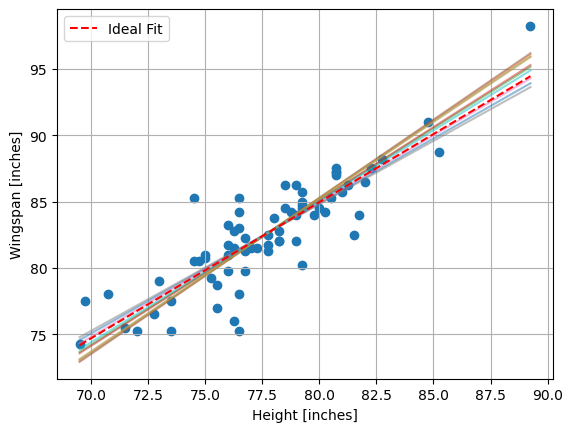

In [22]:
# Train an ensemble of linear models on our data
# and plot their trajectories.
#
# Run this cell

height = draft_data.height_no_shoes.data
wingspan = draft_data.wingspan.data

num_models = 10
trajectories = [[] for i in range(num_models)]
models = [LinearModel() for i in range(num_models)]

num_epochs = 10
step_size = 1e-4

for n in range(num_epochs):
    for model_id, model in enumerate(models):
        y_pred = model(height)
        loss = mean_squared_error_mygrad(y_pred, wingspan)
        loss.backward()

        trajectories[model_id].append((model.m.item(), model.b.item()))
        gradient_step(model.parameters, learning_rate=learning_rate)

trajectories = np.array(trajectories)
graph_linear_regression_mse(height, wingspan, trajectory=trajectories)

fig, ax = plt.subplots()

ax.scatter(height, wingspan)
m, b = ordinary_least_squares(height, wingspan)

x = np.linspace(height.min(), height.max(), 1000)

for n, model in enumerate(models):
    ax.plot(x, model.m * x + model.b, alpha=0.5)
ax.plot(x, m * x + b, c="red", ls="--", label="Ideal Fit")
ax.legend()
ax.grid(True)
ax.set_xlabel("Height [inches]")
ax.set_ylabel("Wingspan [inches]");

What is causing this stagnation in our optimization procedure?
What is it about the shape of the "landscape" of $\mathscr{L}_{MSE}$ that appears to keep our model from learning parameters that fit more closely to $(m^*, b^*)$?
Consider these questions in light of the fact that we use the same learning rate for updating both $m$ and $b$.

If you are working with others, discuss this with a neighbor and note your theories here.

*SOLUTION HERE*    

### Using Normalized Data

The intense sensitivity of $\mathscr{L}_{MSE}$ to changes in $m$ in comparison to changes in $b$ occurs because our data is centered far from the origin $(x=0, y=0)$.
Thus, minute adjustments to $m$ cause a dramatic change to the predictions produced by our model near $(x=80, y=85)$, whereas changes to $b$ that are comparable in magnitude have a much less significant impact on the prediction quality.
This is why $\mathscr{L}_{MSE}$ looks like a flat valley along the $b$ axis compared to its steep slopes along the $m$ axis.
Take sometime to reflect on this and test this statement if it isn't making sense at first.

To remedy this we will want to **normalize our data** so that the normalized height and wingspan values both have a mean of $0$ and a standard deviation of $1$.
Using this normalized data will help to produce a loss landscape that features comparable curvatures along the $m$ and $b$ directions.

See that the following function will normalize an array of data in this way.

In [23]:
def norm(x):
    """
    Returns `x_normed` such that `x_normed.mean()` is 0 
    and `x_normed.std()` is 1.
    
    Parameters
    ----------
    x : array_like, shape-(N,)
    
    Returns
    -------
    normed_x : array_like, shape-(N,)
        The normalized data"""
    return (x - x.mean()) / x.std()

Lets normalize our height and wingspan data and plot it.

In [24]:
normed_height = norm(height)
normed_wingspan = norm(wingspan)

Compute the mean and standard deviation of both `normed_height` and `normed_wingspan` and explicitly confirm that they have the expected values (you should check four values in total).

In [31]:
#*SOLUTION HERE*
assert np.isclose(normed_height.mean(), 0)
assert np.isclose(normed_height.std(), 1)

assert np.isclose(normed_wingspan.mean(), 0)
assert np.isclose(normed_wingspan.std(), 1)

Let's plot this normalized dataset.

Text(0, 0.5, 'Wingspan [unitless]')

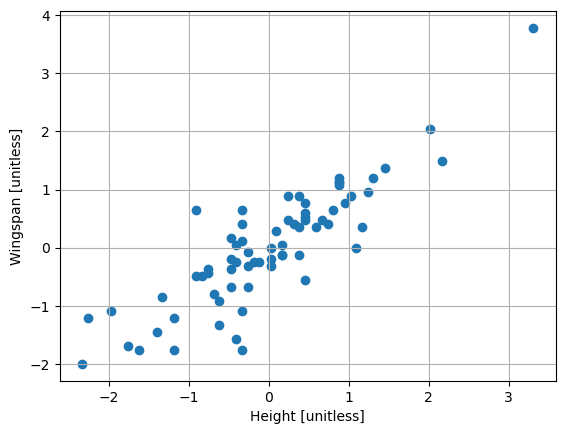

In [26]:
# Run this cell
fig, ax = plt.subplots()
ax.scatter(normed_height, normed_wingspan)
ax.grid()
ax.set_xlabel("Height [unitless]")
ax.set_ylabel("Wingspan [unitless]")

Note that the scales of the numbers on the x and y axes have changed: now our data is centered on $(0, 0)$ and most of the values fall within $[-1, 1]$. 
That being said, the actual distribution of the data points relative to one another is entirely unchanged!
That is, we have not in any way manipulated the patterns or relationships between height and wingspan that was encoded in the raw data. 

Let's try "training" our model again, but this time we will use our normalized data.
Note how `dist_from_target` evolved here versus before - it should be very close to $0$ by then end of training. 

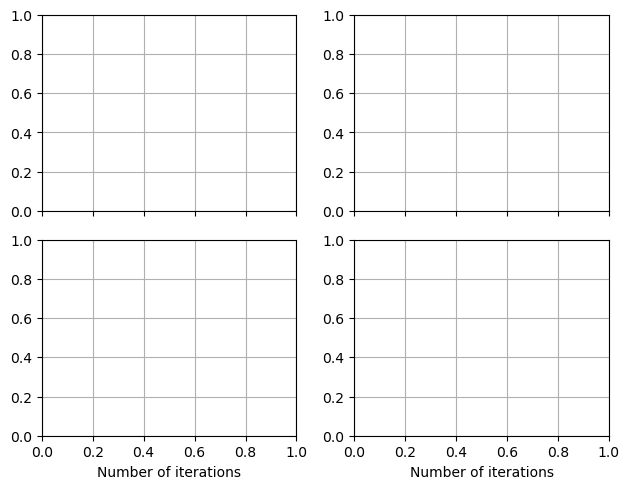

In [27]:
# Run this cell

plotter, fig, ax = create_plot(["loss", "m", "b", "dist_from_target"], ncols=2, last_n_batches=50)

In [28]:
# Run this cell

trajectory = []

model = LinearModel()

# note that we are training for many more epochs
# and with a much larger learning rate
num_epochs = 100
learning_rate = 1e-1

true_params_normed = np.array(ordinary_least_squares(normed_height, normed_wingspan))

In the following cell you will need to copy the training-loop code from above and paste it here. Then, you will replace:
- `height` -> `normed_height`
- `wingspan` -> `normed_wingspan`
- `true_params` -> `true_params_normed`



In [32]:
# Paste your earlier training-loop code here, but replace:
# height -> normed_height
# wingspan -> normed_wingspan
# true_params -> true_params_normed

# You can hit <Escape>+F to bring up a find-and-replace window in Jupyter
# to update height -> normed_height, etc.
# (but make sure to only update *this* cell, not the whole notebook)

# for n in range(num_epochs):
#     ...
#
for n in range(num_epochs):
    y_pred = model(normed_height)
    loss = mean_squared_error_mygrad(y_pred, normed_wingspan)
    loss.backward()

    plotter.set_train_batch(
        dict(
            loss=loss,
            m=model.m.item(),
            b=model.b.item(),
            dist_from_target=dist_from_true(model.parameters, true_params_normed),
        ),
        batch_size=len(height),
    )
    trajectory.append((model.m.item(), model.b.item()))
    gradient_step(model.parameters, learning_rate=learning_rate)

plotter.plot()

# Run this cell and exampine the plot

How close is our approximate solution to the exact one?

In [33]:
# prints the distance between our approximate solution and the exact one
train_metrics = plotter.to_xarray("train").batch
print("distance from target:", round(train_metrics.dist_from_target[-1].item(), 2))

distance from target: 0.0


Let's visualize the landscape for $\mathscr{L}(m,b; (\hat{x}_n, \hat{y}_n)_{n=0}^{N-1})$ where $(\hat{x}_n, \hat{y}_n)_{n=0}^{N-1}$ represents our normalized data.

/var/folders/rk/9p1bkflx7xqfp9blzn6sypv00000gn/T/ipykernel_7228/2126346202.py:93: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


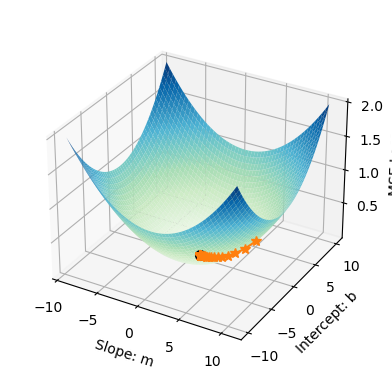

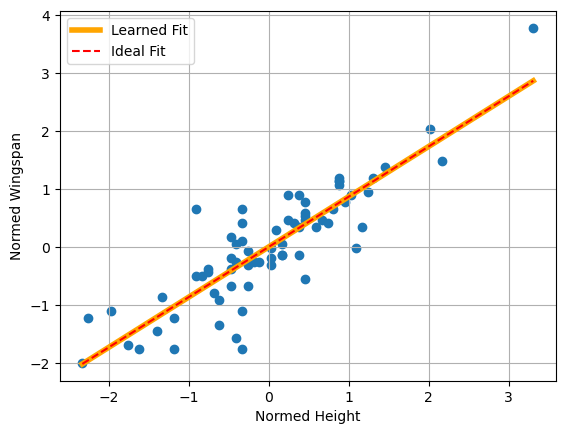

In [34]:
# Run this

graph_linear_regression_mse(normed_height, normed_wingspan, trajectory=trajectory)

fig, ax = plt.subplots()

ax.scatter(normed_height, normed_wingspan)
m, b =  ordinary_least_squares(normed_height, normed_wingspan)

x = np.linspace(normed_height.min(), normed_height.max(), 1000)

ax.plot(x, model.m * x + model.b, c="orange", label="Learned Fit", lw="4")
ax.plot(x, m * x + b, c="red", ls= "--", label="Ideal Fit")
ax.legend()
ax.grid(True)
ax.set_xlabel("Normed Height")
ax.set_ylabel("Normed Wingspan");

See that the landscape no longer looks so flat – adjusting $b$ and $m$ have comparable impacts on the quality of our model's predictions.
Thus gradient descent will be much more effective at guiding our model's parameters towards $(m^*, b^*)$.
Accordingly, our learned model now arrives at parameter values  that are very close to $(m^*, b^*)$
This is all thanks to our having normalized our data before training on it.

To see how much more reliable this training regimen is, let's train an ensemble of models, each with different initial parameters, and see that they all arrive very close to the same terminus.

/var/folders/rk/9p1bkflx7xqfp9blzn6sypv00000gn/T/ipykernel_7228/2126346202.py:93: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11


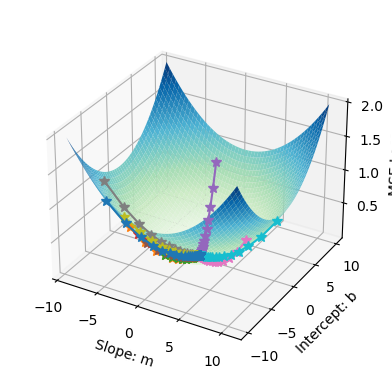

In [35]:
# training an ensemble of models on normalized data

num_models = 10
trajectories = [[] for i in range(num_models)]
models = [LinearModel() for i in range(num_models)]

num_epochs = 100
step_size = 1E-1

for n in range(num_epochs):
    for model_id, model in enumerate(models):
        y_pred = model(normed_height)
        loss = mean_squared_error_mygrad(y_pred, normed_wingspan)
        loss.backward()

        trajectories[model_id].append((model.m.item(), model.b.item()))
        gradient_step(model.parameters, learning_rate=learning_rate)

trajectories = np.array(trajectories)

fig, ax = graph_linear_regression_mse(normed_height, normed_wingspan, trajectory=trajectories)

We should see that – no matter what the initial guess of $m$ and $b$ – gradient-based optimization always leads us very close to the optimal solution, at the bottom of this bowl.

### Re-Scaling Our Model's Predictions

Although we see that our model learns well on the normalized data, note that we no longer can simply feed a height (measured in inches) to our model and get a wingspan predicted in inches – our model "expects" normalized data, and it's learned parameters will produce predicted wingspans on this "normalized" scale.
I.e. it was trained to fit:

\begin{equation}
\hat{y} = m \hat{x} + b
\end{equation}

where 
\begin{align}
\hat{x} &= \frac{x - \bar{x}}{\mathrm{Std}[x]}\\
\hat{y} &= \frac{y - \bar{y}}{\mathrm{Std}[y]}
\end{align}

$\bar{x}$ is the mean height of our observed data; $\mathrm{Std}[x]$ is the corresponding standard deviation.
$\bar{y}$ is the mean height of our observed data; $\mathrm{Std}[y]$ is the corresponding standard deviation.

Given this, complete the following function that will permit us to pass "raw" heights to our model and for us to get "raw" wingspan predictions back.

Hint: Take the above equation that transforms $y$ into $\hat{y}$ and rewrite it so that $\hat{y}$ is transformed to $y$.
The output of our model, trained on normalized data, represents $\hat{y}^{\mathrm{(pred)}}$ and we need to transform it into $y^{\mathrm{(pred)}}$ so that the prediction represents a wingspan in inches - as expressed in the original (raw) data.

In [37]:
def processed_predictions(
    model,
    x,
    height_mean=height.mean(),
    height_std=height.std(),
    wingspan_mean=wingspan.mean(),
    wingspan_std=wingspan.std(),
):
    """ Given one or more new input heights, x (measured in) inches, uses the 
    provided linear model that was trainined on normalized data, to return 
    the predicted wingspan in inches.
    
    Parameters
    ----------
    model : Callable[[array_like], Tensor]
        The linear model trained on normalized data
    
    x : array_like, shape-(N,)
        N new observed height values, measured in inches.
        We want to make predictions about these values

    height_mean : float
        The mean of the height training data [inches]
    
    height_std : float
        The std-dev of the height training data  [inches]
        
    wingspan_mean : float
        The mean of the wingspan training data  [inches]
    
    wingspan_std : float
        The std-dev of the wingspan training data  [inches]
    
    Returns
    -------
    numpy.ndarray, shape-(N,)
        The N predicted wingspans, in inches, produced by the model
    
    Notes
    -----
    Call `.data` on your model's output so that it produces a numpy array
    and not a mygrad tensor.
    """
    # This function will:
    # 1. Normalize the new heights (x) using the original dataset's 
    #    statistics. 
    #
    # 2. Use the trained model to predict (normalized) wingspans, given
    #    the normalized heights.
    #
    # 3. Un-normalize the predicted values, using the original dataset's 
    #    statistics, so that the returned values are the predicted wingspans 
    #    in units of inches.

    # Normalize the input heights (`x`) using the provided statistics: `height_mean` and `height_std`
    normed_x = (x - height_mean) / height_std  # <COGSTUB>
    
    # Have the model predict normalized wingspans using these normalized heights.
    normed_y = model(normed_x)  # <COGSTUB> 
    
    # `normed_y` represents unitless wingspans that our model predicted.
    # We need to "re-scale" these, so that they carry interpretable units (inches)
    #
    # Un-normalize `normed_y` using the provided statistics: `wingspan_mean` and `wingspan_std`
    y = normed_y * wingspan_std + wingspan_mean  # <COGSTUB>
    
    return y

Finally, let's plot predictions from our learned model, but by using `processed_predictions` to normalize the input data and "rescale" the resulting predictions to produce predicted wingspans on the desired scale (i.e. in inches).
We should see that our learned model matches the ideal linear fit very closely.

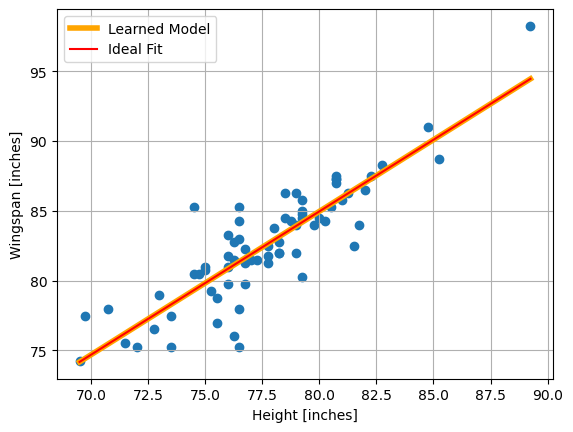

In [38]:
fig, ax = plt.subplots()

ax.scatter(height, wingspan)

x = np.linspace(height.min(), height.max(), 1000)

# Produce the processed predictions of your model, given the input `x`,
# and assign the output to the variable `y`

y = processed_predictions(model, x)  # <COGSTUB>


ax.plot(x, y, color="orange", lw=4, label="Learned Model")


m, b = ordinary_least_squares(height, wingspan,)
ax.plot(x, m * x + b, c="red", label="Ideal Fit")
ax.grid(True)
ax.legend()
ax.set_xlabel("Height [inches]")
ax.set_ylabel("Wingspan [inches]");

## Summary

This exercise notebook provides the glue that connects the essential concepts that we have learned about thus far in our journey towards understanding machine learning using neural networks (i.e. deep learning).
Namely, we:

- Defined a mathematical model designed to transform observed data into useful predictions.
  - In this case the model was a simple linear model, but we could easily generalize it to more complicated mathematical forms.
  - It was natural for us to represent our model in terms of a [Python class](https://www.pythonlikeyoumeanit.com/module_4.html), since this allowed us to keep track of our model's parameters, our initialization scheme for the parameter values, and the code for performing a "forward pass" of our model on input data, all in one place.
- Utilized automatic differentiation by using MyGrad's tensors and mathematical operations to store our model's parameters and to perform all of the mathematics associated with evaluating the model and the loss function for our problem. 
   - This gave us easy access to the gradient of the loss function with respect to our model's parameters. 
- Searched for optimal model parameter values - ones that minimize our loss function - by using gradient descent.
   - We were introduced to the term "epoch" as an indicator that we had processed our dataset in its entirety.
   - The selection of the learning rate was not informed by gradient descent or any obvious mathematics; we basically just made a guess at an appropriate value here (more on this later).
   - This style of updating a mathematical model by using data containing the desired (or "true") predictions is known as "supervised learning".
- Saw that the shape of our loss landscape had an impact on the efficacy of the gradient descent process, and, furthermore, that normalizing our data (to have a mean of $0$ and standard deviation of $1$) could help reshape this loss landscape to improve the model optimization process.
   - This dynamic was rooted in the fact that the scales of the numbers associated with our raw data were such that making a small adjustment to $m$ made a much bigger impact on the quality of our model's predictions than did making a comparable adjustment to $b$.
   - Normalizing our data helped to place $m$ and $b$ on more of an equal footing in terms of their influence on the model's predictions, and this led to healthier optimization performance, since we are using a single learning rate across all of the model's parameters.
   - This parameter-scale balancing act will prove to be important for other, more sophisticated mathematical models as well, and data normalization will regularly be leveraged to help with this.

It is recommended that you revisit and revise this notebook regularly to keep the lessons learned here in hand.

In practice, we will never have the luxury of glimpsing the full loss landscape associated with our model and dataset as we did here.
This is because our models will almost inevitable contain too many parameters to permit a plot of a 3D surface.
So we wont have the benefit of qualitatively inspecting the trajectory of our gradient-based descent down the loss's surface, nor will we be able to easily glean the features of the surface's shape that prove difficult to traverse.
For this reason, it is important to thoroughly internalize the lessons learned from this simple problem and prepare ourselves to anticipate their manifestations in more complicated scenarios - where we will need to be much more savvy and clever to deal with them.